# Работа команды №9 в рамках итогового проекта "ML Intensive Yandex Academy spring 2024" специализации Яндекс Лицея.


## Участники:

Чернышев Андрей Юрьевич - лид

Упадышев Артём Алексеевич

Павленко Иван Дмитриевич

Григорянц Никита Григорьевич

## Ментор: Бордунов Александр

# Загрузка необходимых библиотек

In [ ]:
from IPython.display import clear_output
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import os

Общая функция для вывода истории

In [ ]:
def output_history(loss, val_loss, acc, val_acc):
    clear_output()

    plt.figure(figsize=(24, 4))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(np.arange(len(loss)), loss)
    plt.plot(np.arange(len(val_loss)), val_loss)
    plt.legend(["loss", "val_loss"])
    plt.yscale('log')
    plt.grid()

    plt.figure(figsize=(24, 4))
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(len(acc)), acc)
    plt.plot(np.arange(len(val_acc)), val_acc)
    plt.legend(["acc", "val_acc"])
    plt.yscale("log")
    plt.grid()


Общая функция для загрузки фотографий с лёгкими, автоматическим разделением на тестовую и тренировочную выборки

In [ ]:
STATIC_NUMBER = 0
STATIC_TRAIN_SPLIT = 0.8
STATIC_TEST_SPLIT = 1 - STATIC_TRAIN_SPLIT
BATCH = 2700
def data_load_lungs():
    global STATIC_NUMBER
    global STATIC_TRAIN_SPLIT
    global STATIC_TEST_SPLIT
    global BATCH
    df_a = pd.read_csv("data/train_answers.csv", dtype="object")
    df_a = df_a.drop("id", axis=1)
    X_train = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_images", f"img_{i}.png")
                )
            ) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + int(BATCH * STATIC_TRAIN_SPLIT))
    ])
    df = df_a.iloc[STATIC_NUMBER: STATIC_NUMBER + int(BATCH * STATIC_TRAIN_SPLIT)]
    df = pd.get_dummies(df, drop_first=False)
    y_train = df.to_numpy()
    STATIC_NUMBER += int(BATCH * STATIC_TRAIN_SPLIT) % 27000
    X_test = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_images", f"img_{i}.png")
                )
            ) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + int(BATCH * STATIC_TEST_SPLIT))
    ])
    df = df_a.iloc[STATIC_NUMBER: STATIC_NUMBER + int(BATCH * STATIC_TEST_SPLIT)]
    df = pd.get_dummies(df, drop_first=False)
    y_test = df.to_numpy()
    return (X_train, y_train, X_test, y_test)


Как выглядит рабочая директория:

    data:
        train_images
        test_images
        train_lung_masks
    MODELS:
        .h5 files
    MAIN.ipynb


# Неудачные модели

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Функция для загрузки фотографий для kNN

In [ ]:
STATIC_NUMBER = 0
STATIC_TRAIN_SPLIT = 0.8
STATIC_TEST_SPLIT = 1 - STATIC_TRAIN_SPLIT
BATCH = 27000

def data_load_for_knn():
    global STATIC_NUMBER
    global STATIC_TRAIN_SPLIT
    global STATIC_TEST_SPLIT
    global BATCH
    df_a = pd.read_csv(os.path.join(os.getcwd(), "data", "train_answers.csv"))
    df_a = df_a.drop("id", axis=1)
    X_train = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_images", f"img_{i}.png")
                )
            ).reshape(256*256) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + int(BATCH * STATIC_TRAIN_SPLIT))
    ])
    df = df_a.iloc[STATIC_NUMBER: STATIC_NUMBER + int(BATCH * STATIC_TRAIN_SPLIT)]
    Y_train = df.to_numpy()
    STATIC_NUMBER += int(BATCH * STATIC_TRAIN_SPLIT) % 27000
    X_test = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_images", f"img_{i}.png")
                )
            ).reshape(256*256) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + int(BATCH * STATIC_TEST_SPLIT))
    ])
    df = df_a.iloc[STATIC_NUMBER: STATIC_NUMBER + int(BATCH * STATIC_TEST_SPLIT)]
    Y_test = df.to_numpy()
    return (X_train, Y_train, X_test, Y_test)

In [ ]:
print("knn")
neigh = KNeighborsClassifier(n_neighbors=6)
X_train_for_knn, Y_train_for_knn, X_test_for_knn, Y_test_for_knn = data_load_for_knn()
neigh.fit(X_train_for_knn, Y_train_for_knn)
acc = neigh.score(X_test_for_knn, Y_test_for_knn)
print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))

Была достигнута точность около 75%

## UNet + dense network

Сначала наща команда попыталась реализовать различные модели, определяющие класс по сегментированным изображениям.
Для сегментации изображений используем известную модель UNet, как советует в своей выпускной квалификационной работе тов. Григорьев Д. В.

Определим функцию подачи данных с изображениями и масками

In [ ]:
STATIC_NUMBER = 0
STATIC_TRAIN_SPLIT = 0.8
STATIC_TEST_SPLIT = 1 - STATIC_TRAIN_SPLIT
BATCH = 2700

def data_load_masks():
    global STATIC_NUMBER
    global STATIC_TRAIN_SPLIT
    global STATIC_TEST_SPLIT
    global BATCH
    X_train = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_images", f"img_{i}.png")
                )
            ) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + int(BATCH * STATIC_TRAIN_SPLIT))
    ])
    Y_train = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_lung_masks", f"img_{i}.png")
                )
            ) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + int(BATCH * STATIC_TRAIN_SPLIT))
    ])
    STATIC_NUMBER += int(BATCH * STATIC_TRAIN_SPLIT)
    X_test = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_images", f"img_{i}.png")
                )
            ) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER  + int(BATCH * STATIC_TEST_SPLIT))
    ])
    Y_test = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_lung_masks", f"img_{i}.png")
                )
            ) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + int(BATCH * STATIC_TEST_SPLIT))
    ])
    return (X_train, Y_train, X_test, Y_test)


Определим архитектуру UNet

In [ ]:
def UNet(depth: int, input_size=(256, 256, 1)) -> tf.keras.models.Model:
    skip = list()
    inputs = tf.keras.Input(input_size)
    x = inputs
    for i in range(depth):
        image_shape = (input_size[0] // (2 ** i), input_size[1] // (2 ** i), 1)
        x = tf.keras.layers.Conv2D(2 ** (i + 4), (3, 3), padding="same", input_shape=image_shape)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2D(2 ** (i + 4), (3, 3), padding="same")(x)
        x = tf.keras.layers.Activation("relu")(x)
        skip.append(x)
        if i + 1 < depth:
            x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(skip[i])
    for i in range(depth - 1, 0, -1):
        x = tf.keras.layers.UpSampling2D()(skip[i])
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.concatenate([x, skip[i - 1]])
        x = tf.keras.layers.Conv2D(2 ** (i + 4), (3, 3), padding="same")(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2D(2 ** (i + 4), (3, 3), padding="same")(x)
        x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding="same")(x)
    return tf.keras.models.Model(inputs, x)

unet = UNet(8)
unet.compile(
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["acc"]
)
unet.summary()

In [ ]:
loss, val_loss, acc, val_acc = list(), list(), list(), list()
for epoch in range(10):
    X_train, Y_train, X_test, Y_test = data_load_masks()
    cash = unet.fit(X_train, Y_train, epochs=10, batch_size=60, validation_data=(X_test, Y_test))
    loss, val_loss, acc, val_acc = loss + cash.history["loss"], val_loss + cash.history["val_loss"], acc + cash.history["acc"], val_acc + cash.history["val_acc"]

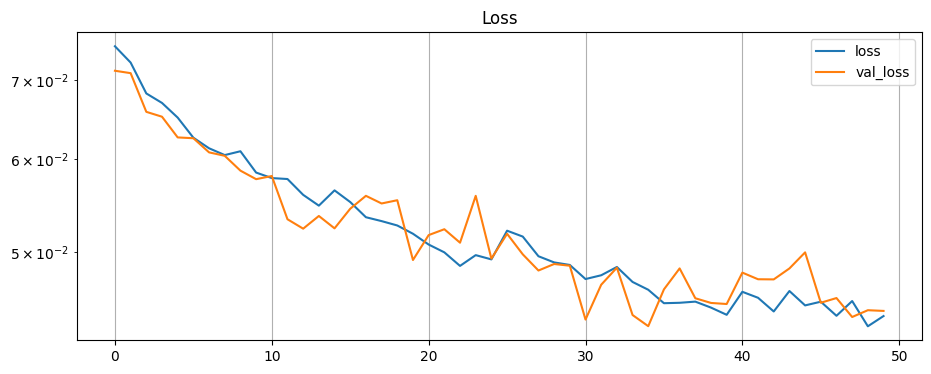

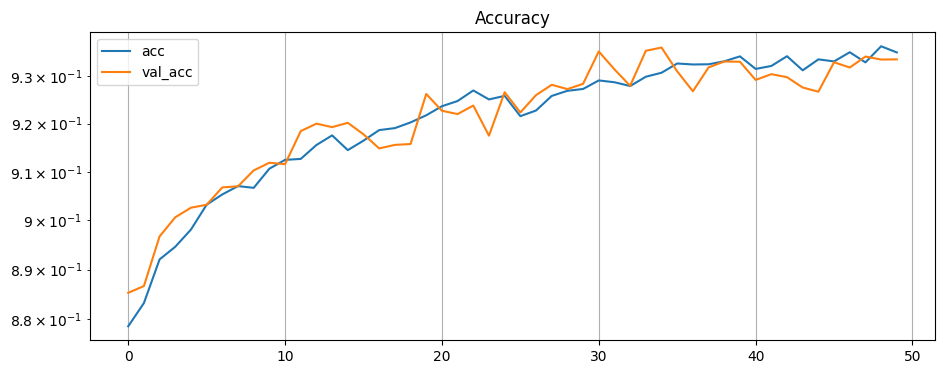

In [ ]:
output_history(loss, val_loss, acc, val_acc)

Если продолжить обучение, то через 50 эпох эта реализация UNet выдаст 95% точности

Определим архитектуру модели, определяющей класс

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2048, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['acc']
)

In [ ]:
loss, val_loss, acc, val_acc = list(), list(), list(), list()
for epoch in range(10):
    X_train, y_train, X_test, y_test = data_load_lungs()
    X_train = segment(X_train, unet)
    X_test = segment(X_test, unet)
    cash = model.fit(X_train, y_train, epochs=10, batch_size=60, validation_data=(X_test, y_test))
    loss, val_loss, acc, val_acc = loss + cash.history["loss"], val_loss + cash.history["val_loss"], acc + cash.history["acc"], val_acc + cash.history["val_acc"]

17/17 [==============================] - 17s 994ms/step
Epoch 1/10
36/36 [==============================] - 10s 267ms/step - loss: 6.1773 - acc: 0.3773 - val_loss: 1.0454 - val_acc: 0.4212
Epoch 2/10
36/36 [==============================] - 9s 245ms/step - loss: 1.0367 - acc: 0.4773 - val_loss: 1.0122 - val_acc: 0.4861
Epoch 3/10
36/36 [==============================] - 8s 210ms/step - loss: 0.9694 - acc: 0.5389 - val_loss: 0.9770 - val_acc: 0.5102
Epoch 4/10
36/36 [==============================] - 8s 225ms/step - loss: 0.9483 - acc: 0.5412 - val_loss: 0.9657 - val_acc: 0.5028
Epoch 5/10
36/36 [==============================] - 10s 269ms/step - loss: 0.9333 - acc: 0.5343 - val_loss: 0.9629 - val_acc: 0.5325
Epoch 6/10
36/36 [==============================] - 11s 302ms/step - loss: 0.8988 - acc: 0.5523 - val_loss: 0.9481 - val_acc: 0.5176
Epoch 7/10
36/36 [==============================] - 15s 409ms/step - loss: 0.8820 - acc: 0.5417 - val_loss: 1.0269 - val_acc: 0.4304
Epoch 8/10
36/36

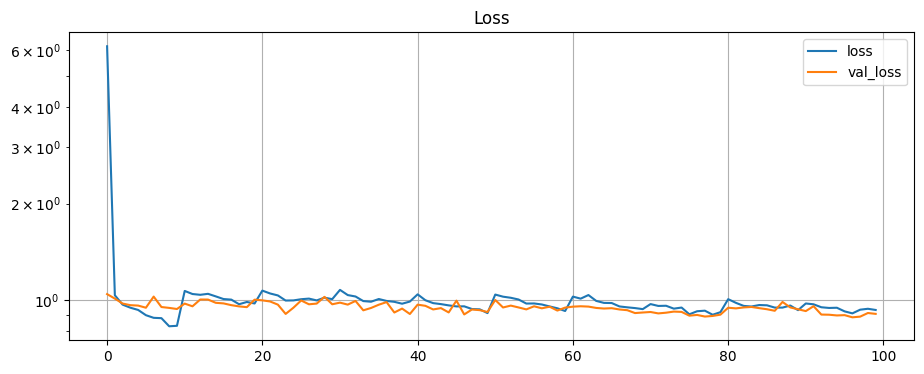

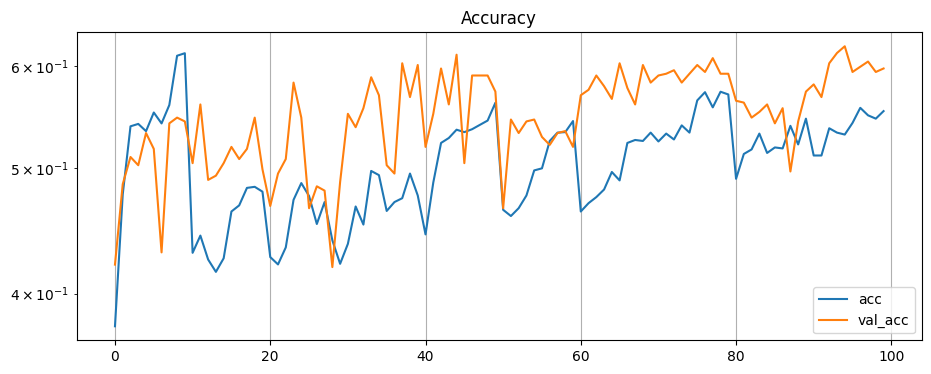

In [ ]:
output_history(loss, val_loss, acc, val_acc)

Мы не согласимся с мнением Григорьева Д. В., который утверждает, что такой результат является приемлимым, ведь kNN справляется не хуже. Откажемся от этой идеи.

## VGG16

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape=(256,256,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=4096,activation="relu"))
model.add(tf.keras.layers.Dense(units=4096,activation="relu"))
model.add(tf.keras.layers.Dense(units=3, activation="softmax"))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                   

In [ ]:
loss, val_loss, acc, val_acc = list(), list(), list(), list()
for epoch in range(10):
    X_train, Y_train, X_test, Y_test = data_load_lungs()
    cash = model.fit(X_train, Y_train, epochs=3, batch_size=60, validation_data=(X_test, Y_test))
    loss, val_loss, acc, val_acc = loss + cash.history["loss"], val_loss + cash.history["val_loss"], acc + cash.history["acc"], val_acc + cash.history["val_acc"]

Epoch 1/3
36/36 [==============================] - 1421s 40s/step - loss: 1.1243 - acc: 0.3227 - val_loss: 1.0993 - val_acc: 0.3043
Epoch 2/3
36/36 [==============================] - 2098s 59s/step - loss: 1.0989 - acc: 0.3352 - val_loss: 1.0980 - val_acc: 0.3581
Epoch 3/3
36/36 [==============================] - 2173s 60s/step - loss: 1.0986 - acc: 0.3449 - val_loss: 1.0975 - val_acc: 0.3581
Epoch 1/3
36/36 [==============================] - 1803s 50s/step - loss: 1.0982 - acc: 0.3500 - val_loss: 1.0975 - val_acc: 0.3432
Epoch 2/3
36/36 [==============================] - 1772s 49s/step - loss: 1.0978 - acc: 0.3500 - val_loss: 1.0972 - val_acc: 0.3432
Epoch 3/3
36/36 [==============================] - 1780s 50s/step - loss: 1.0979 - acc: 0.3500 - val_loss: 1.0970 - val_acc: 0.3432
Epoch 1/3
36/36 [==============================] - 1807s 50s/step - loss: 1.0982 - acc: 0.3569 - val_loss: 1.0958 - val_acc: 0.3655
Epoch 2/3
36/36 [==============================] - 1765s 49s/step - loss: 1.

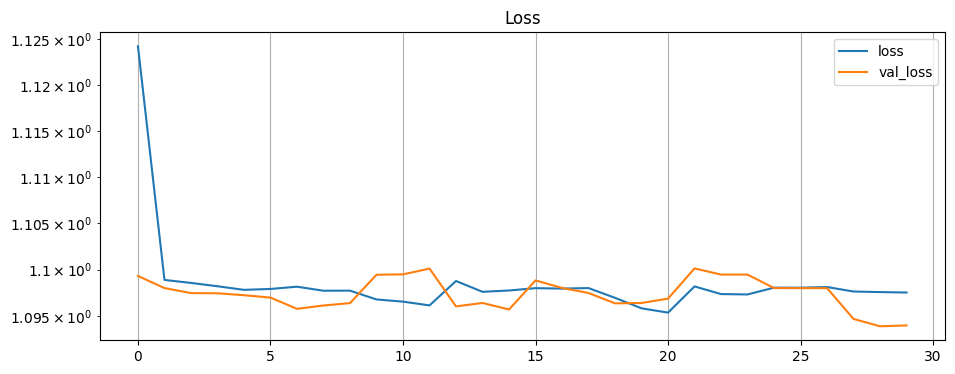

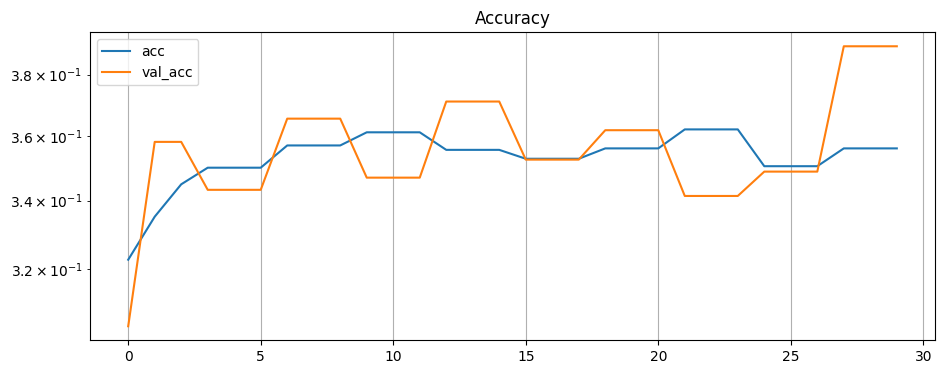

In [ ]:
output_history(loss, val_loss, acc, val_acc)

##AlexNet


In [ ]:
AlexNet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(256, 256, 1), filters=96, kernel_size=(11, 11), strides=4, padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding="valid"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2048),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

In [ ]:
AlexNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 96)        11712     
                                                                 
 activation (Activation)     (None, 64, 64, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 27, 27, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                   

In [ ]:
loss, val_loss, acc, val_acc = list(), list(), list(), list()
for epoch in range(10):
    print(f"\n\t\tEpoch {epoch + 1}\n")
    X_train, Y_train, X_test, Y_test = data_load_lungs()
    cash = AlexNet.fit(X_train, Y_train, epochs=5, batch_size=60, validation_data=(X_test, Y_test))
    loss, val_loss, acc, val_acc = loss + cash.history["loss"], val_loss + cash.history["val_loss"], acc + cash.history["acc"], val_acc + cash.history["val_acc"]
    AlexNet.save_weights(f"_{epoch}_AlexNet.h5")

Epoch 1/5
36/36 [==============================] - 89s 2s/step - loss: 0.9710 - acc: 0.5477 - val_loss: 1.3156 - val_acc: 0.3432
Epoch 2/5
36/36 [==============================] - 92s 3s/step - loss: 0.9577 - acc: 0.5468 - val_loss: 1.1440 - val_acc: 0.3432
Epoch 3/5
36/36 [==============================] - 89s 2s/step - loss: 0.8952 - acc: 0.5870 - val_loss: 1.2079 - val_acc: 0.3432
Epoch 4/5
36/36 [==============================] - 89s 2s/step - loss: 0.8730 - acc: 0.6125 - val_loss: 1.1243 - val_acc: 0.3432
Epoch 5/5
36/36 [==============================] - 89s 2s/step - loss: 0.8594 - acc: 0.6185 - val_loss: 1.1384 - val_acc: 0.3432

Epoch 1/5
36/36 [==============================] - 89s 2s/step - loss: 0.8638 - acc: 0.6139 - val_loss: 1.0483 - val_acc: 0.3673
Epoch 2/5
36/36 [==============================] - 89s 2s/step - loss: 0.8215 - acc: 0.6338 - val_loss: 1.0378 - val_acc: 0.3785
Epoch 3/5
36/36 [==============================] - 89s 2s/step - loss: 0.7843 - acc: 0.6551 - val_loss: 1.0701 - val_acc: 0.3655
Epoch 4/5
36/36 [==============================] - 89s 2s/step - loss: 0.7902 - acc: 0.6551 - val_loss: 1.0891 - val_acc: 0.4304
Epoch 5/5
36/36 [==============================] - 89s 2s/step - loss: 0.7477 - acc: 0.6903 - val_loss: 0.8844 - val_acc: 0.6234

Epoch 1/5
36/36 [==============================] - 89s 2s/step - loss: 0.7533 - acc: 0.6731 - val_loss: 0.7738 - val_acc: 0.6827
Epoch 2/5
36/36 [==============================] - 89s 2s/step - loss: 0.7124 - acc: 0.7046 - val_loss: 0.9679 - val_acc: 0.5380
Epoch 3/5
36/36 [==============================] - 90s 2s/step - loss: 0.7039 - acc: 0.7009 - val_loss: 0.8225 - val_acc: 0.6401
Epoch 4/5
36/36 [==============================] - 89s 2s/step - loss: 0.6792 - acc: 0.7167 - val_loss: 0.9128 - val_acc: 0.5547
Epoch 5/5
36/36 [==============================] - 89s 2s/step - loss: 0.6802 - acc: 0.7167 - val_loss: 0.6559 - val_acc: 0.7421

Epoch 1/5
36/36 [==============================] - 89s 2s/step - loss: 0.6937 - acc: 0.7065 - val_loss: 0.8929 - val_acc: 0.6048
Epoch 2/5
36/36 [==============================] - 89s 2s/step - loss: 0.6341 - acc: 0.7454 - val_loss: 1.0979 - val_acc: 0.4156
Epoch 3/5
36/36 [==============================] - 89s 2s/step - loss: 0.6509 - acc: 0.7310 - val_loss: 1.0220 - val_acc: 0.4453
Epoch 4/5
36/36 [==============================] - 90s 2s/step - loss: 0.5814 - acc: 0.7657 - val_loss: 0.8784 - val_acc: 0.6067
Epoch 5/5
36/36 [==============================] - 89s 2s/step - loss: 0.5601 - acc: 0.7764 - val_loss: 1.0644 - val_acc: 0.4434

Epoch 1/5
36/36 [==============================] - 93s 3s/step - loss: 0.6452 - acc: 0.7426 - val_loss: 0.6607 - val_acc: 0.7273
Epoch 2/5
36/36 [==============================] - 473s 13s/step - loss: 0.5904 - acc: 0.7593 - val_loss: 0.6626 - val_acc: 0.7310
Epoch 3/5
36/36 [==============================] - 70s 2s/step - loss: 0.6292 - acc: 0.7491 - val_loss: 0.7715 - val_acc: 0.6475
Epoch 4/5
36/36 [==============================] - 75s 2s/step - loss: 0.5452 - acc: 0.7921 - val_loss: 0.6524 - val_acc: 0.7291
Epoch 5/5
36/36 [==============================] - 76s 2s/step - loss: 0.5217 - acc: 0.7884 - val_loss: 0.6198 - val_acc: 0.7440

Epoch 1/5
36/36 [==============================] - 74s 2s/step - loss: 0.5975 - acc: 0.7602 - val_loss: 0.5730 - val_acc: 0.7792
Epoch 2/5
36/36 [==============================] - 74s 2s/step - loss: 0.5285 - acc: 0.7968 - val_loss: 0.4839 - val_acc: 0.8237
Epoch 3/5
36/36 [==============================] - 74s 2s/step - loss: 0.4966 - acc: 0.8088 - val_loss: 0.5357 - val_acc: 0.8089
Epoch 4/5
36/36 [==============================] - 74s 2s/step - loss: 0.4962 - acc: 0.7995 - val_loss: 0.5360 - val_acc: 0.7885
Epoch 5/5
36/36 [==============================] - 74s 2s/step - loss: 0.4594 - acc: 0.8181 - val_loss: 0.4779 - val_acc: 0.8367

Epoch 1/5
36/36 [==============================] - 78s 2s/step - loss: 0.5289 - acc: 0.7921 - val_loss: 0.5648 - val_acc: 0.7885
Epoch 2/5
36/36 [==============================] - 78s 2s/step - loss: 0.4638 - acc: 0.8208 - val_loss: 0.6126 - val_acc: 0.7495
Epoch 3/5
36/36 [==============================] - 78s 2s/step - loss: 0.4599 - acc: 0.8144 - val_loss: 0.5941 - val_acc: 0.7607
Epoch 4/5
36/36 [==============================] - 78s 2s/step - loss: 0.4055 - acc: 0.8468 - val_loss: 0.5119 - val_acc: 0.8182
Epoch 5/5
36/36 [==============================] - 78s 2s/step - loss: 0.3691 - acc: 0.8514 - val_loss: 0.5331 - val_acc: 0.7978

Epoch 1/5
36/36 [==============================] - 74s 2s/step - loss: 0.4886 - acc: 0.8148 - val_loss: 0.6902 - val_acc: 0.7551
Epoch 2/5
36/36 [==============================] - 74s 2s/step - loss: 0.5369 - acc: 0.7833 - val_loss: 0.4911 - val_acc: 0.8126
Epoch 3/5
36/36 [==============================] - 75s 2s/step - loss: 0.4181 - acc: 0.8384 - val_loss: 0.4607 - val_acc: 0.8145
Epoch 4/5
36/36 [==============================] - 74s 2s/step - loss: 0.4194 - acc: 0.8361 - val_loss: 0.6344 - val_acc: 0.7607
Epoch 5/5
36/36 [==============================] - 110s 3s/step - loss: 0.4060 - acc: 0.8384 - val_loss: 0.5278 - val_acc: 0.7811

Epoch 1/5
36/36 [==============================] - 113s 3s/step - loss: 0.4463 - acc: 0.8356 - val_loss: 0.4176 - val_acc: 0.8423
Epoch 2/5
36/36 [==============================] - 111s 3s/step - loss: 0.3958 - acc: 0.8417 - val_loss: 0.4337 - val_acc: 0.8367
Epoch 3/5
36/36 [==============================] - 110s 3s/step - loss: 0.3800 - acc: 0.8532 - val_loss: 0.4761 - val_acc: 0.8033
Epoch 4/5
36/36 [==============================] - 111s 3s/step - loss: 0.3462 - acc: 0.8620 - val_loss: 0.4511 - val_acc: 0.8200
Epoch 5/5
36/36 [==============================] - 110s 3s/step - loss: 0.2999 - acc: 0.8861 - val_loss: 0.5045 - val_acc: 0.8015

Epoch 1/5
36/36 [==============================] - 114s 3s/step - loss: 0.5100 - acc: 0.8019 - val_loss: 0.6627 - val_acc: 0.7254
Epoch 2/5
36/36 [==============================] - 108s 3s/step - loss: 0.4291 - acc: 0.8319 - val_loss: 0.5031 - val_acc: 0.8071
Epoch 3/5
36/36 [==============================] - 129s 4s/step - loss: 0.3658 - acc: 0.8606 - val_loss: 0.5429 - val_acc: 0.8033
Epoch 4/5
36/36 [==============================] - 110s 3s/step - loss: 0.3416 - acc: 0.8644 - val_loss: 0.5364 - val_acc: 0.8182
Epoch 5/5
36/36 [==============================] - 117s 3s/step - loss: 0.3076 - acc: 0.8796 - val_loss: 0.7702 - val_acc: 0.7403

По итогам обучения была достигнута точность 82%

Объективно, VGG16, MobileNet и GoogleNet плохо справились с задачей. Обучение слишком дорогое и долгое, результат неудовлетворителен. Команда №9 начала работу над новыми свёрточными нейронными сетями.

## CNN

Было сделано множество реализаций CNN

In [ ]:
# CNN2_0
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(256, 256, 1), filters=256, kernel_size=(4, 4), strides=4, padding="same"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(4, 4), strides=4, padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(units=8),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       4352      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       1048832   
                                                                 
 activation (Activation)     (None, 16, 16, 256)       0         
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dropout (Dropout)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 256)               16777472  
                                                                 
 batch_normalization (Batch  (None, 256)               1

In [ ]:
loss, val_loss, acc, val_acc = list(), list(), list(), list()
for epoch in range(10):
    X_train, Y_train, X_test, Y_test = data_load_lungs()
    cash = model.fit(X_train, Y_train, epochs=8, batch_size=60, validation_data=(X_test, Y_test))
    loss, val_loss, acc, val_acc = loss + cash.history["loss"], val_loss + cash.history["val_loss"], acc + cash.history["acc"], val_acc + cash.history["val_acc"]

Epoch 1/8
36/36 [==============================] - 21s 572ms/step - loss: 0.9416 - acc: 0.5685 - val_loss: 1.0815 - val_acc: 0.3562
Epoch 2/8
36/36 [==============================] - 21s 583ms/step - loss: 0.7754 - acc: 0.6644 - val_loss: 1.0201 - val_acc: 0.4768
Epoch 3/8
36/36 [==============================] - 21s 587ms/step - loss: 0.7315 - acc: 0.6903 - val_loss: 0.9217 - val_acc: 0.6197
Epoch 4/8
36/36 [==============================] - 24s 669ms/step - loss: 0.6610 - acc: 0.7403 - val_loss: 0.9251 - val_acc: 0.5714
Epoch 5/8
36/36 [==============================] - 23s 638ms/step - loss: 0.6106 - acc: 0.7532 - val_loss: 0.7417 - val_acc: 0.7199
Epoch 6/8
36/36 [==============================] - 22s 619ms/step - loss: 0.5538 - acc: 0.7810 - val_loss: 0.7755 - val_acc: 0.6660
Epoch 7/8
36/36 [==============================] - 24s 666ms/step - loss: 0.4999 - acc: 0.8074 - val_loss: 0.7793 - val_acc: 0.6549
Epoch 8/8
36/36 [==============================] - 119s 3s/step - loss: 0.45

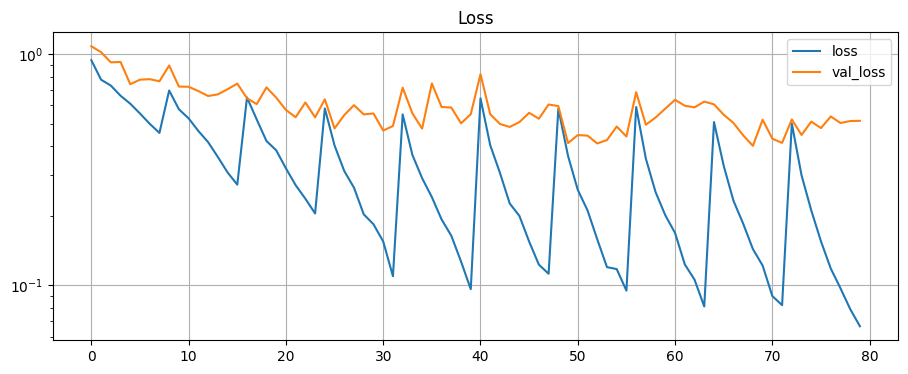

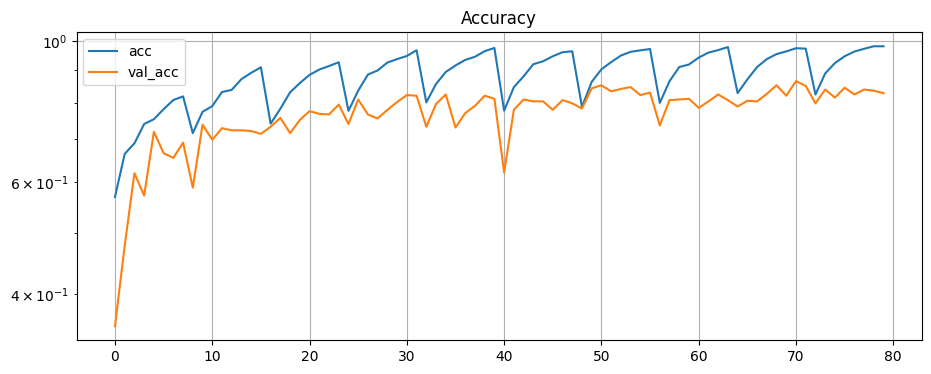

In [ ]:
output_history(loss, val_loss, acc, val_acc)

In [ ]:
#CNN3_0
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(256, 256, 1), filters=512, kernel_size=(4, 4), strides=4, padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(input_shape=(256, 256, 1), filters=512, kernel_size=(4, 4), strides=4, padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(4, 4), strides=4, padding="same"),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=8),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 512)       8704      
                                                                 
 activation (Activation)     (None, 64, 64, 512)       0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 512)       4194816   
                                                                 
 activation_1 (Activation)   (None, 16, 16, 512)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         4

In [ ]:
loss, val_loss, acc, val_acc = list(), list(), list(), list()
for epoch in range(10):
    X_train, Y_train, X_test, Y_test = data_load_lungs()
    cash = model.fit(X_train, Y_train, epochs=6, batch_size=60, validation_data=(X_test, Y_test))
    loss, val_loss, acc, val_acc = loss + cash.history["loss"], val_loss + cash.history["val_loss"], acc + cash.history["acc"], val_acc + cash.history["val_acc"]

Epoch 1/6
36/36 [==============================] - 92s 3s/step - loss: 0.7060 - acc: 0.7204 - val_loss: 0.5574 - val_acc: 0.7737
Epoch 2/6
36/36 [==============================] - 97s 3s/step - loss: 0.6812 - acc: 0.7361 - val_loss: 0.5556 - val_acc: 0.7922
Epoch 3/6
36/36 [==============================] - 101s 3s/step - loss: 0.6767 - acc: 0.7319 - val_loss: 0.5518 - val_acc: 0.7755
Epoch 4/6
36/36 [==============================] - 91s 3s/step - loss: 0.6693 - acc: 0.7477 - val_loss: 0.6415 - val_acc: 0.7328
Epoch 5/6
36/36 [==============================] - 94s 3s/step - loss: 0.6703 - acc: 0.7231 - val_loss: 0.5693 - val_acc: 0.7811
Epoch 6/6
36/36 [==============================] - 90s 3s/step - loss: 0.6470 - acc: 0.7509 - val_loss: 0.5770 - val_acc: 0.7755
Epoch 1/6
36/36 [==============================] - 89s 2s/step - loss: 0.6734 - acc: 0.7241 - val_loss: 0.5316 - val_acc: 0.8015
Epoch 2/6
36/36 [==============================] - 88s 2s/step - loss: 0.6746 - acc: 0.7315 - va

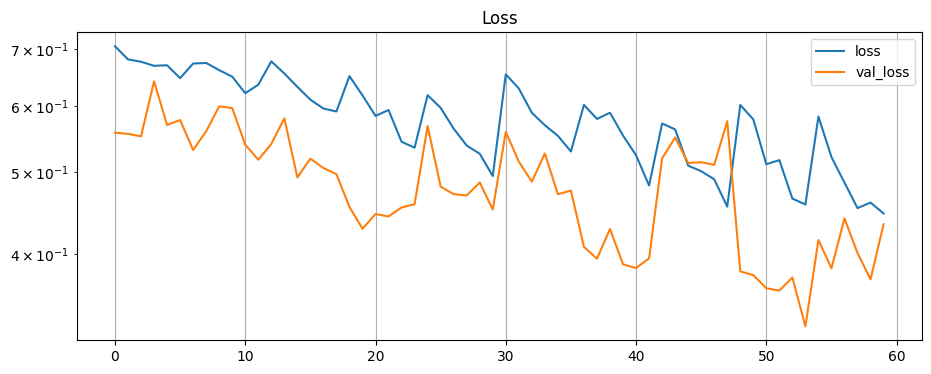

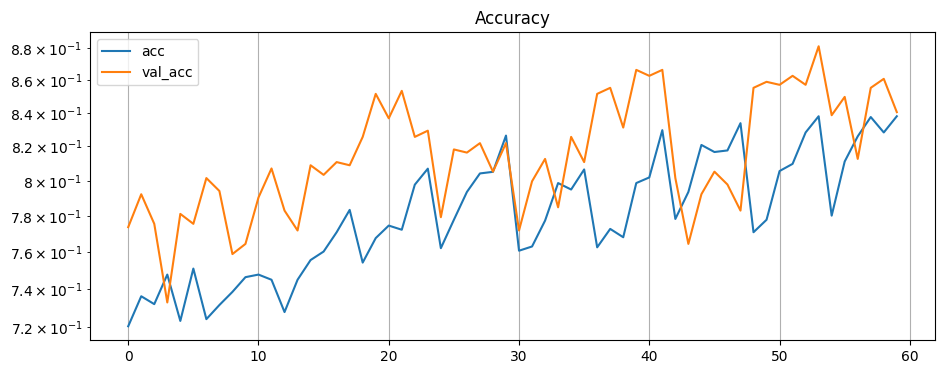

In [ ]:
output_history(loss, val_loss, acc, val_acc)

In [ ]:
# CNN4_0
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(256, 256, 1), filters=8, kernel_size=(16, 16), strides=2, padding="same"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(16, 16), padding="same"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(4, 4), padding="same"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       2056      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      32784     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      8224      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 average_pooling2d (Average  (None, 64, 64, 64)        0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                        

In [ ]:
loss, val_loss, acc, val_acc = list(), list(), list(), list()
for epoch in range(10):
    X_train, Y_train, X_test, Y_test = data_load_lungs()
    cash = model.fit(X_train, Y_train, epochs=3, batch_size=60, validation_data=(X_test, Y_test))
    loss, val_loss, acc, val_acc = loss + cash.history["loss"], val_loss + cash.history["val_loss"], acc + cash.history["acc"], val_acc + cash.history["val_acc"]
    output_history(loss, val_loss, acc, val_acc)

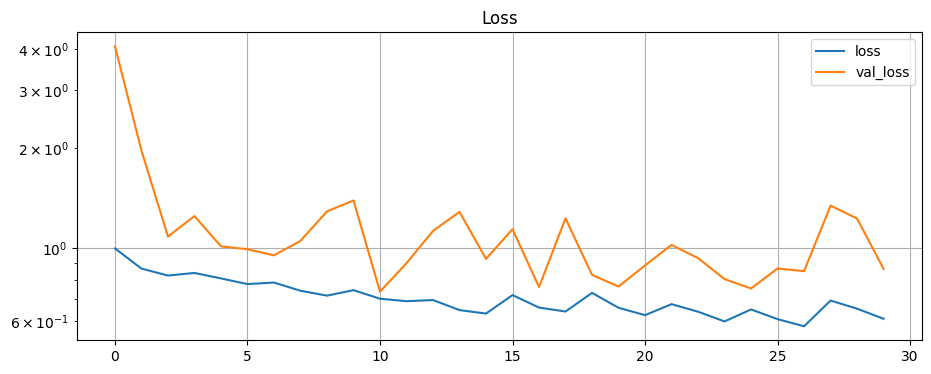

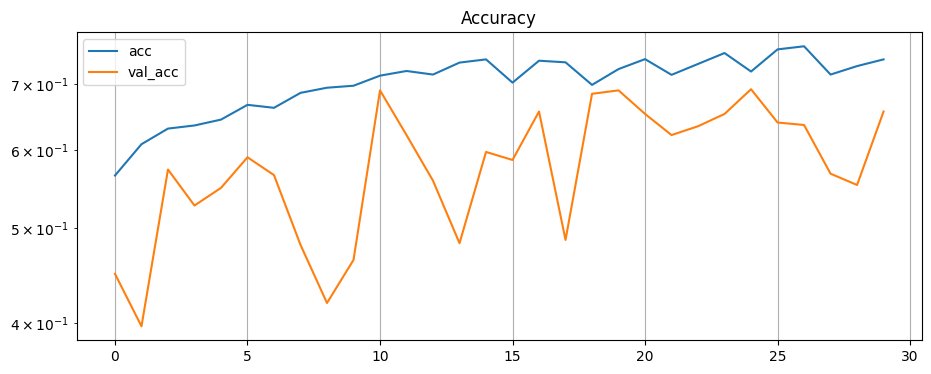

In [ ]:
output_history(loss, val_loss, acc, val_acc)

In [ ]:
# CNN4_3
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(256, 256, 1), filters=16, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding="same"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding="same"),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=8),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.F1Score()]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 dropout (Dropout)           (None, 256, 256, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 average_pooling2d (Average  (None, 32, 32, 64)        0

In [ ]:
loss, val_loss, acc, val_acc = list(), list(), list(), list()
for epoch in range(10):
    X_train, Y_train, X_test, Y_test = data_load_lungs()
    cash = model.fit(X_train, Y_train, epochs=3, batch_size=60, validation_data=(X_test, Y_test))
    loss, val_loss, acc, val_acc = loss + cash.history["loss"], val_loss + cash.history["val_loss"], acc + cash.history["acc"], val_acc + cash.history["val_acc"]

Epoch 1/3
36/36 [==============================] - 50s 1s/step - loss: 0.9509 - acc: 0.5847 - val_loss: 1.9814 - val_acc: 0.3766
Epoch 2/3
36/36 [==============================] - 55s 2s/step - loss: 0.7380 - acc: 0.6898 - val_loss: 2.8145 - val_acc: 0.4545
Epoch 3/3
36/36 [==============================] - 63s 2s/step - loss: 0.6529 - acc: 0.7421 - val_loss: 0.9090 - val_acc: 0.5993
Epoch 1/3
36/36 [==============================] - 65s 2s/step - loss: 0.6708 - acc: 0.7231 - val_loss: 1.1097 - val_acc: 0.5325
Epoch 2/3
36/36 [==============================] - 67s 2s/step - loss: 0.5449 - acc: 0.7907 - val_loss: 1.1349 - val_acc: 0.4508
Epoch 3/3
36/36 [==============================] - 69s 2s/step - loss: 0.4413 - acc: 0.8375 - val_loss: 0.8425 - val_acc: 0.6345
Epoch 1/3
36/36 [==============================] - 67s 2s/step - loss: 0.6282 - acc: 0.7370 - val_loss: 1.0865 - val_acc: 0.6438
Epoch 2/3
36/36 [==============================] - 73s 2s/step - loss: 0.4653 - acc: 0.8227 - val

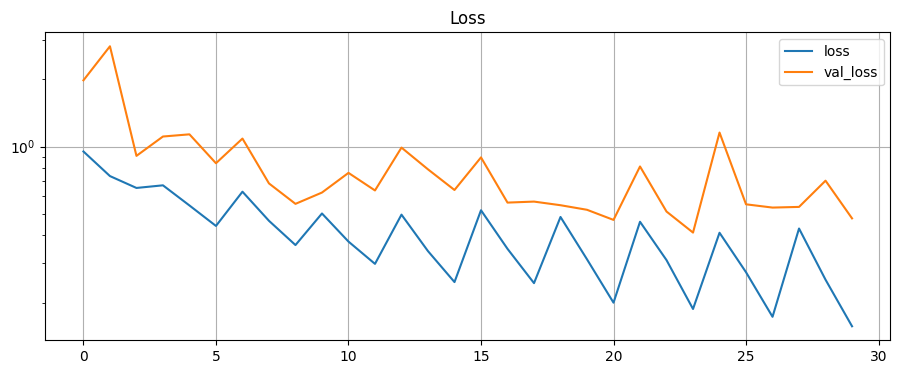

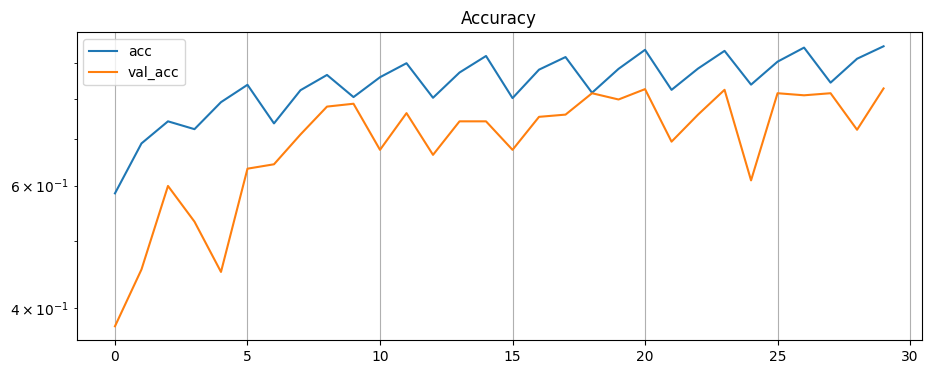

In [ ]:
output_history(loss, val_loss, acc, val_acc)

## Переход к более совершенным моделям

Проанализировав опыт этих моделей, было принято решение строить модели c dropout=0.5 между каждым FC блоком и таким же dropout между блоками из двух последовательных conv слоёв и макспулинга.
Два conv слоя, между которыми ReLU, позволяют хорошо аппроксимировать любые функции. Делая между ними dropout, мы портим эту аппроксимацию. После двух таких блоков стоит делать гиперболический тангенс, потом проводить макс пулинг и делать dropout. Это позволит избежать запоминания тренировочной выборки. Даже если один блок что-то запомнит, следующий не сможет использовать это "знание", если половина его весов отключена.

In [ ]:
# Подтвержу действительность своих слов - не будем ставить дропауты между слоями
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(256, 256, 1), filters=32, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=8),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                        

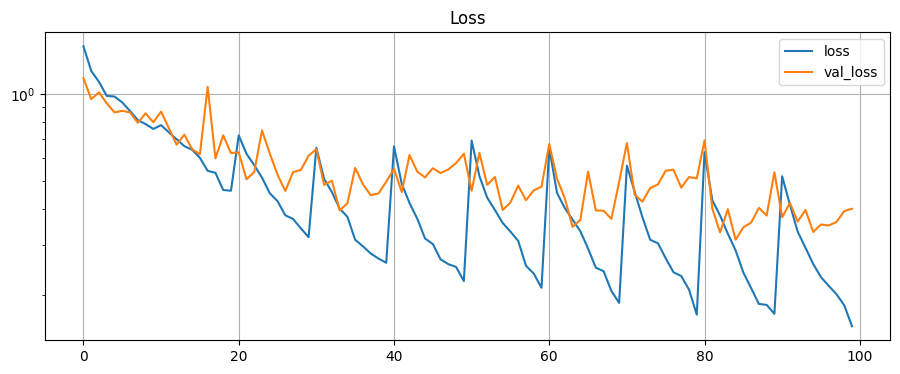

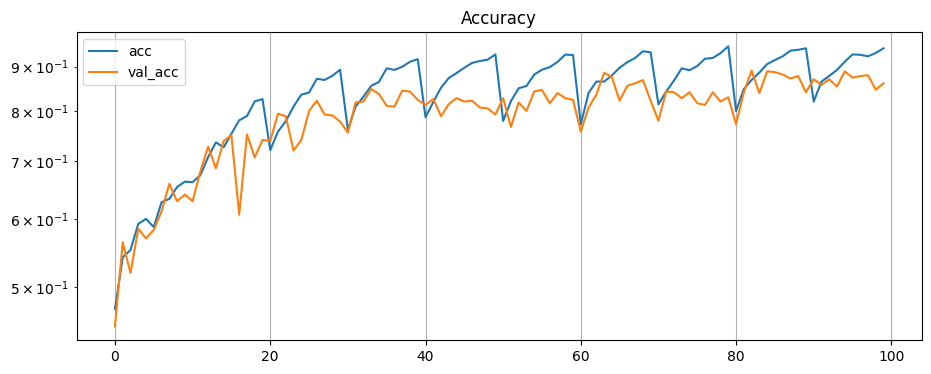

In [ ]:
output_history(loss, val_loss, acc, val_acc)

In [ ]:
# dethick
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(256, 256, 1), filters=32, kernel_size=4, padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=4, padding="same"),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2, padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=4, padding="same"),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=128, kernel_size=4, strides=2, padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=4, padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=16),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=3, activation="softmax"),
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)
model.summary()

История обучения данной модели была утеряна. Но при полном обучении она даёт более 90% F1-score на тестовой выборке на kaggle.
Для таких результатов нужно проделать >> 100 эпох обучения

## UNet + dethick

In [ ]:
unet = tf.keras.models.load_model(os.path.join(os.getcwd(), "MODELS", "unet.h5"))

In [ ]:
loss, val_loss, acc, val_acc = list(), list(), list(), list()
for epoch in range(27000 // BATCH):
    print(f"Epoch {epoch}")
    X_train, Y_train, X_test, Y_test = data_load_lungs()
    X_train, X_test = segment(X_train, unet), segment(X_test, unet)
    cash = model.fit(X_train, Y_train, epochs=10, batch_size=60, validation_data=(X_test, Y_test))
    loss, val_loss, acc, val_acc = loss + cash.history["loss"], val_loss + cash.history["val_loss"], acc + cash.history["acc"], val_acc + cash.history["val_acc"]
    model.save(os.path.join(os.getcwd(), "dethink_unet.h5"))

Epoch 0
17/17 [==============================] - 12s 713ms/step
Epoch 1/10
36/36 [==============================] - 161s 4s/step - loss: 1.2925 - acc: 0.3972 - val_loss: 1.0617 - val_acc: 0.4731
Epoch 2/10
36/36 [==============================] - 162s 5s/step - loss: 1.1232 - acc: 0.4606 - val_loss: 1.1012 - val_acc: 0.3711
Epoch 3/10
36/36 [==============================] - 173s 5s/step - loss: 1.0216 - acc: 0.5278 - val_loss: 1.0814 - val_acc: 0.4657
Epoch 4/10
36/36 [==============================] - 174s 5s/step - loss: 0.9672 - acc: 0.5463 - val_loss: 1.0750 - val_acc: 0.3989
Epoch 5/10
36/36 [==============================] - 181s 5s/step - loss: 0.9575 - acc: 0.5667 - val_loss: 1.0271 - val_acc: 0.4471
Epoch 6/10
36/36 [==============================] - 185s 5s/step - loss: 0.9062 - acc: 0.5894 - val_loss: 1.0164 - val_acc: 0.4564
Epoch 7/10
36/36 [==============================] - 181s 5s/step - loss: 0.8643 - acc: 0.6144 - val_loss: 1.1152 - val_acc: 0.3673
Epoch 8/10
36/36 [=

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 11s 650ms/step
Epoch 1/10
36/36 [==============================] - 168s 5s/step - loss: 0.8839 - acc: 0.6056 - val_loss: 1.0448 - val_acc: 0.4731
Epoch 2/10
36/36 [==============================] - 165s 5s/step - loss: 0.8491 - acc: 0.6273 - val_loss: 1.0330 - val_acc: 0.4768
Epoch 3/10
36/36 [==============================] - 166s 5s/step - loss: 0.8326 - acc: 0.6306 - val_loss: 1.1422 - val_acc: 0.4212
Epoch 4/10
36/36 [==============================] - 164s 5s/step - loss: 0.7978 - acc: 0.6472 - val_loss: 0.9913 - val_acc: 0.5139
Epoch 5/10
36/36 [==============================] - 163s 5s/step - loss: 0.7867 - acc: 0.6519 - val_loss: 0.8988 - val_acc: 0.5937
Epoch 6/10
36/36 [==============================] - 153s 4s/step - loss: 0.7784 - acc: 0.6583 - val_loss: 1.0020 - val_acc: 0.5306
Epoch 7/10
36/36 [==============================] - 153s 4s/step - loss: 0.7689 - acc: 0.6708 - val_loss: 0.9433 - val_acc: 0.5807
Epoch 8/10
36/36 [=========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 13s 755ms/step
Epoch 1/10
36/36 [==============================] - 170s 5s/step - loss: 0.8254 - acc: 0.6394 - val_loss: 0.8901 - val_acc: 0.6345
Epoch 2/10
36/36 [==============================] - 171s 5s/step - loss: 0.7905 - acc: 0.6690 - val_loss: 0.9314 - val_acc: 0.5751
Epoch 3/10
36/36 [==============================] - 177s 5s/step - loss: 0.7523 - acc: 0.6787 - val_loss: 0.9084 - val_acc: 0.6030
Epoch 4/10
36/36 [==============================] - 177s 5s/step - loss: 0.7328 - acc: 0.6838 - val_loss: 0.8102 - val_acc: 0.6586
Epoch 5/10
36/36 [==============================] - 178s 5s/step - loss: 0.7179 - acc: 0.6935 - val_loss: 0.8541 - val_acc: 0.6234
Epoch 6/10
36/36 [==============================] - 177s 5s/step - loss: 0.6971 - acc: 0.7102 - val_loss: 0.8384 - val_acc: 0.6438
Epoch 7/10
36/36 [==============================] - 175s 5s/step - loss: 0.6772 - acc: 0.7157 - val_loss: 0.7713 - val_acc: 0.6809
Epoch 8/10
36/36 [=========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 13s 741ms/step
Epoch 1/10
36/36 [==============================] - 174s 5s/step - loss: 0.7386 - acc: 0.6861 - val_loss: 0.6047 - val_acc: 0.7662
Epoch 2/10
36/36 [==============================] - 174s 5s/step - loss: 0.7101 - acc: 0.7014 - val_loss: 0.9367 - val_acc: 0.6067
Epoch 3/10
36/36 [==============================] - 182s 5s/step - loss: 0.6816 - acc: 0.7125 - val_loss: 0.6388 - val_acc: 0.7477
Epoch 4/10
36/36 [==============================] - 182s 5s/step - loss: 0.6791 - acc: 0.7218 - val_loss: 0.7267 - val_acc: 0.6865
Epoch 5/10
36/36 [==============================] - 186s 5s/step - loss: 0.6489 - acc: 0.7417 - val_loss: 0.8445 - val_acc: 0.6271
Epoch 6/10
36/36 [==============================] - 179s 5s/step - loss: 0.6087 - acc: 0.7634 - val_loss: 0.6257 - val_acc: 0.7384
Epoch 7/10
36/36 [==============================] - 180s 5s/step - loss: 0.6190 - acc: 0.7583 - val_loss: 0.8026 - val_acc: 0.6401
Epoch 8/10
36/36 [=========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 13s 741ms/step
Epoch 1/10
36/36 [==============================] - 179s 5s/step - loss: 0.7009 - acc: 0.7153 - val_loss: 0.7297 - val_acc: 0.7087
Epoch 2/10
36/36 [==============================] - 174s 5s/step - loss: 0.6650 - acc: 0.7231 - val_loss: 0.8425 - val_acc: 0.6531
Epoch 3/10
36/36 [==============================] - 169s 5s/step - loss: 0.6351 - acc: 0.7444 - val_loss: 0.8766 - val_acc: 0.6475
Epoch 4/10
36/36 [==============================] - 158s 4s/step - loss: 0.5996 - acc: 0.7671 - val_loss: 0.7487 - val_acc: 0.6772
Epoch 5/10
36/36 [==============================] - 157s 4s/step - loss: 0.5716 - acc: 0.7894 - val_loss: 0.7583 - val_acc: 0.6735
Epoch 6/10
36/36 [==============================] - 156s 4s/step - loss: 0.5646 - acc: 0.7889 - val_loss: 0.7453 - val_acc: 0.6920
Epoch 7/10
36/36 [==============================] - 169s 5s/step - loss: 0.5447 - acc: 0.7852 - val_loss: 0.7562 - val_acc: 0.6846
Epoch 8/10
36/36 [=========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 13s 741ms/step
Epoch 1/10
36/36 [==============================] - 159s 4s/step - loss: 0.7397 - acc: 0.7153 - val_loss: 1.0490 - val_acc: 0.5844
Epoch 2/10
36/36 [==============================] - 161s 4s/step - loss: 0.6736 - acc: 0.7245 - val_loss: 0.7058 - val_acc: 0.7050
Epoch 3/10
36/36 [==============================] - 167s 5s/step - loss: 0.6471 - acc: 0.7398 - val_loss: 0.6796 - val_acc: 0.7310
Epoch 4/10
36/36 [==============================] - 168s 5s/step - loss: 0.6266 - acc: 0.7495 - val_loss: 0.7549 - val_acc: 0.6865
Epoch 5/10
36/36 [==============================] - 175s 5s/step - loss: 0.5778 - acc: 0.7644 - val_loss: 0.7772 - val_acc: 0.6512
Epoch 6/10
36/36 [==============================] - 178s 5s/step - loss: 0.5561 - acc: 0.7958 - val_loss: 0.7410 - val_acc: 0.6827
Epoch 7/10
36/36 [==============================] - 178s 5s/step - loss: 0.5494 - acc: 0.7880 - val_loss: 0.8015 - val_acc: 0.6438
Epoch 8/10
36/36 [=========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 13s 771ms/step
Epoch 1/10
36/36 [==============================] - 173s 5s/step - loss: 0.7368 - acc: 0.7079 - val_loss: 0.7680 - val_acc: 0.7069
Epoch 2/10
36/36 [==============================] - 176s 5s/step - loss: 0.6608 - acc: 0.7463 - val_loss: 0.5742 - val_acc: 0.7588
Epoch 3/10
36/36 [==============================] - 178s 5s/step - loss: 0.6524 - acc: 0.7389 - val_loss: 0.7221 - val_acc: 0.7013
Epoch 4/10
36/36 [==============================] - 179s 5s/step - loss: 0.5957 - acc: 0.7606 - val_loss: 0.7403 - val_acc: 0.6790
Epoch 5/10
36/36 [==============================] - 176s 5s/step - loss: 0.5731 - acc: 0.7745 - val_loss: 0.6634 - val_acc: 0.7161
Epoch 6/10
36/36 [==============================] - 178s 5s/step - loss: 0.5643 - acc: 0.7866 - val_loss: 0.6256 - val_acc: 0.7458
Epoch 7/10
36/36 [==============================] - 180s 5s/step - loss: 0.5487 - acc: 0.7875 - val_loss: 0.6835 - val_acc: 0.7013
Epoch 8/10
36/36 [=========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 12s 696ms/step
Epoch 1/10
36/36 [==============================] - 167s 5s/step - loss: 0.6717 - acc: 0.7269 - val_loss: 0.6497 - val_acc: 0.7236
Epoch 2/10
36/36 [==============================] - 173s 5s/step - loss: 0.5972 - acc: 0.7704 - val_loss: 0.6124 - val_acc: 0.7458
Epoch 3/10
36/36 [==============================] - 176s 5s/step - loss: 0.5635 - acc: 0.7833 - val_loss: 0.7981 - val_acc: 0.6438
Epoch 4/10
36/36 [==============================] - 174s 5s/step - loss: 0.5511 - acc: 0.7838 - val_loss: 0.5727 - val_acc: 0.7737
Epoch 5/10
36/36 [==============================] - 174s 5s/step - loss: 0.5171 - acc: 0.7944 - val_loss: 0.6485 - val_acc: 0.7236
Epoch 6/10
36/36 [==============================] - 175s 5s/step - loss: 0.5213 - acc: 0.7986 - val_loss: 0.7532 - val_acc: 0.6753
Epoch 7/10
36/36 [==============================] - 186s 5s/step - loss: 0.4806 - acc: 0.8148 - val_loss: 0.6334 - val_acc: 0.7291
Epoch 8/10
36/36 [=========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 12s 679ms/step
Epoch 1/10
36/36 [==============================] - 163s 5s/step - loss: 0.7074 - acc: 0.7250 - val_loss: 0.8385 - val_acc: 0.6827
Epoch 2/10
36/36 [==============================] - 189s 5s/step - loss: 0.6032 - acc: 0.7616 - val_loss: 0.6891 - val_acc: 0.7106
Epoch 3/10
36/36 [==============================] - 194s 5s/step - loss: 0.5758 - acc: 0.7792 - val_loss: 0.7278 - val_acc: 0.6846
Epoch 4/10
36/36 [==============================] - 194s 5s/step - loss: 0.5295 - acc: 0.7870 - val_loss: 0.5668 - val_acc: 0.7644
Epoch 5/10
36/36 [==============================] - 193s 5s/step - loss: 0.5044 - acc: 0.8083 - val_loss: 0.6869 - val_acc: 0.7050
Epoch 6/10
36/36 [==============================] - 194s 5s/step - loss: 0.5132 - acc: 0.8144 - val_loss: 0.7511 - val_acc: 0.6549
Epoch 7/10
36/36 [==============================] - 194s 5s/step - loss: 0.4758 - acc: 0.8167 - val_loss: 0.6643 - val_acc: 0.7087
Epoch 8/10
36/36 [=========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 14s 824ms/step
Epoch 1/10
36/36 [==============================] - 195s 5s/step - loss: 0.6809 - acc: 0.7407 - val_loss: 0.6765 - val_acc: 0.6994
Epoch 2/10
36/36 [==============================] - 192s 5s/step - loss: 0.6023 - acc: 0.7639 - val_loss: 0.7777 - val_acc: 0.6716
Epoch 3/10
36/36 [==============================] - 196s 5s/step - loss: 0.5624 - acc: 0.7894 - val_loss: 0.6653 - val_acc: 0.7310
Epoch 4/10
36/36 [==============================] - 194s 5s/step - loss: 0.5257 - acc: 0.7963 - val_loss: 0.7809 - val_acc: 0.6735
Epoch 5/10
36/36 [==============================] - 195s 5s/step - loss: 0.5008 - acc: 0.8097 - val_loss: 0.7190 - val_acc: 0.7124
Epoch 6/10
36/36 [==============================] - 197s 5s/step - loss: 0.4767 - acc: 0.8204 - val_loss: 0.6508 - val_acc: 0.7273
Epoch 7/10
36/36 [==============================] - 196s 5s/step - loss: 0.4440 - acc: 0.8394 - val_loss: 0.6515 - val_acc: 0.7365
Epoch 8/10
36/36 [=========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


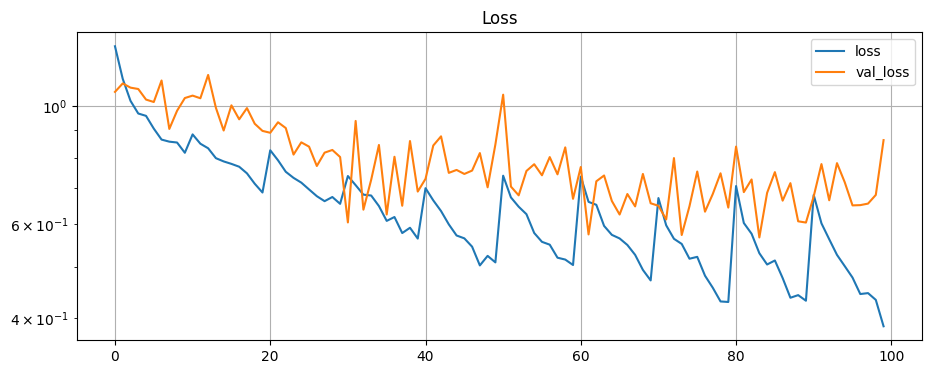

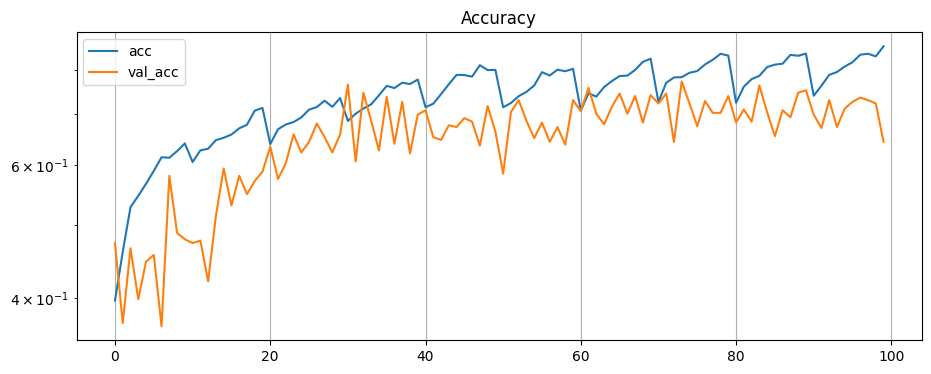

In [ ]:
output_history(loss, val_loss, acc, val_acc)

Результаты оказались хуже, чем без сегментации - F1-score был ниже 66%.

## Аугментация, создание двух моделей с разной аугментацией

План - создать ансамбль из 2-ух моделей на аугментированных данных и модели dethick (Hamed R. Bonab, Fazli Can. A Theoretical Framework on the Ideal Number of Classifiers for Online Ensembles in Data Streams // 25th Conference on Information and Knowledge Management. — USA: ACM, 2016. — doi:10.1145/2983323.2983907)

Определим даталоадер аугментированных данных

In [ ]:
STATIC_NUMBER = 0
STATIC_TRAIN_SPLIT = 0.8
STATIC_TEST_SPLIT = 1 - STATIC_TRAIN_SPLIT
BATCH = 2700
def load_datagen_lungs():
    global STATIC_NUMBER
    global STATIC_TRAIN_SPLIT
    global STATIC_TEST_SPLIT
    global BATCH
    df = pd.read_csv("data/train_answers.csv", dtype="object")
    df = df.drop("id", axis=1)
    df = df.iloc[STATIC_NUMBER: STATIC_NUMBER + BATCH]
    df = pd.get_dummies(df, drop_first=False)
    y = df.to_numpy()
    X = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_images", f"img_{i}.png")
                )
            ) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + BATCH)
    ])
    STATIC_NUMBER += BATCH
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=False,
        vertical_flip = True,
        # у другой модели ровно наоборот - True и False
        validation_split=STATIC_TEST_SPLIT
    )
    gen_train = datagen.flow(X.reshape((BATCH, 256, 256, 1)), y, batch_size=60, subset='training')
    gen_test = datagen.flow(X.reshape((BATCH, 256, 256, 1)), y, batch_size=60, subset='validation')
    return (gen_train, gen_test)


Используем архитектуру dethick-а

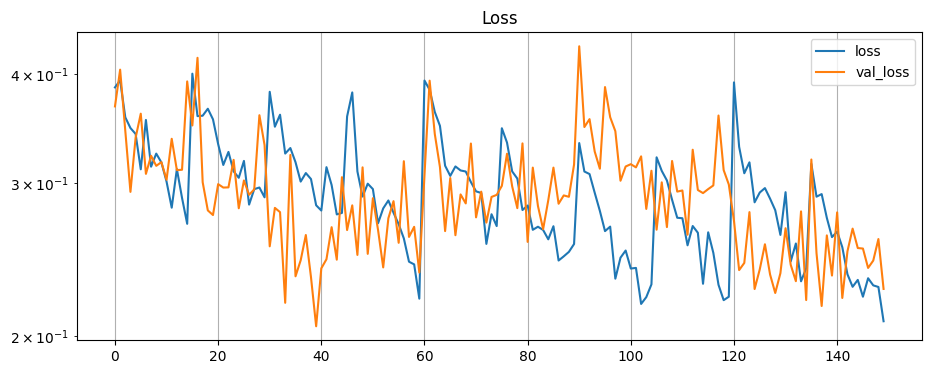

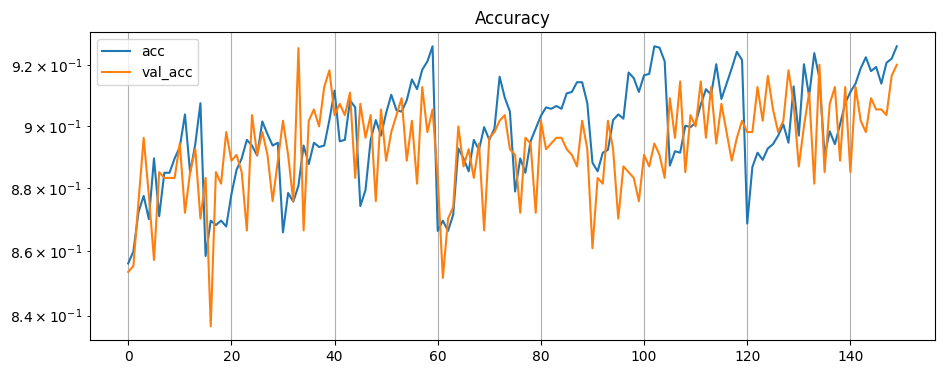

## Ансамбль

In [ ]:
STATIC_NUMBER = 0
STATIC_TRAIN_SPLIT = 0.8
STATIC_TEST_SPLIT = 1 - STATIC_TRAIN_SPLIT
BATCH = 2700
def data_load_lungs():
    global STATIC_NUMBER
    global STATIC_TRAIN_SPLIT
    global STATIC_TEST_SPLIT
    global BATCH
    df_a = pd.read_csv("data/train_answers.csv", dtype="object")
    df_a = df_a.drop("id", axis=1)
    X_train = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_images", f"img_{i}.png")
                )
            ) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + int(BATCH * STATIC_TRAIN_SPLIT))
    ])
    df = df_a.iloc[STATIC_NUMBER: STATIC_NUMBER + int(BATCH * STATIC_TRAIN_SPLIT)]
    df = pd.get_dummies(df, drop_first=False)
    y_train = df.to_numpy()
    STATIC_NUMBER += int(BATCH * STATIC_TRAIN_SPLIT) % 27000
    X_test = np.array([
        np.array(
            PIL.Image.open(
                os.path.join(os.getcwd(), "data", "train_images", f"img_{i}.png")
                )
            ) / 255. for i in range(STATIC_NUMBER, STATIC_NUMBER + int(BATCH * STATIC_TEST_SPLIT))
    ])
    df = df_a.iloc[STATIC_NUMBER: STATIC_NUMBER + int(BATCH * STATIC_TEST_SPLIT)]
    df = pd.get_dummies(df, drop_first=False)
    y_test = df.to_numpy()
    return (X_train, y_train, X_test, y_test)


In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1, self.w2, self.w3 = w1, w2, w3

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2]


In [ ]:
dethick_3 = tf.keras.models.load_model(os.path.join(os.getcwd(), "MODELS", "dethick_3.h5"))
dethick_3 = tf.keras.models.Model(inputs=dethick_3.inputs, outputs=dethick_3.outputs, name="dethick_3")

dethick_aug_0 = tf.keras.models.load_model(os.path.join(os.getcwd(), "MODELS", "dethick_aug_0.h5"))
dethick_aug_0 = tf.keras.models.Model(inputs=dethick_aug_0.inputs, outputs=dethick_aug_0.outputs, name="dethick_aug_0")

dethick_aug_2 = tf.keras.models.load_model(os.path.join(os.getcwd(), "MODELS", "dethick_aug_2.h5"))
dethick_aug_2 = tf.keras.models.Model(inputs=dethick_aug_2.inputs, outputs=dethick_aug_2.outputs, name="dethick_aug_2")

# tf.keras.models.load_model(os.path.join(os.getcwd(), "MODELS", "dethick_aug_1.h5"))
# tf.keras.models.load_model(os.path.join(os.getcwd(), "MODELS", "dethick_aug_4.h5"))

models = [dethick_3, dethick_aug_0, dethick_aug_2]
models_input = tf.keras.layers.Input((256, 256, 1))
models_output = [model(models_input) for model in models]
ensemble_output = WeightedAverageLayer(0.371, 0.379, 0.25)(models_output)
ensemble = tf.keras.models.Model(inputs=models_input, outputs=ensemble_output, name="ensemble")
ensemble.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)
ensemble.summary()


Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 dethick_3 (Functional)      (None, 3)                    2611523   ['input_1[0][0]']             
                                                                                                  
 dethick_aug_0 (Functional)  (None, 3)                    2611523   ['input_1[0][0]']             
                                                                                                  
 dethick_aug_2 (Functional)  (None, 3)                    2611523   ['input_1[0][0]']             
                                                                                           

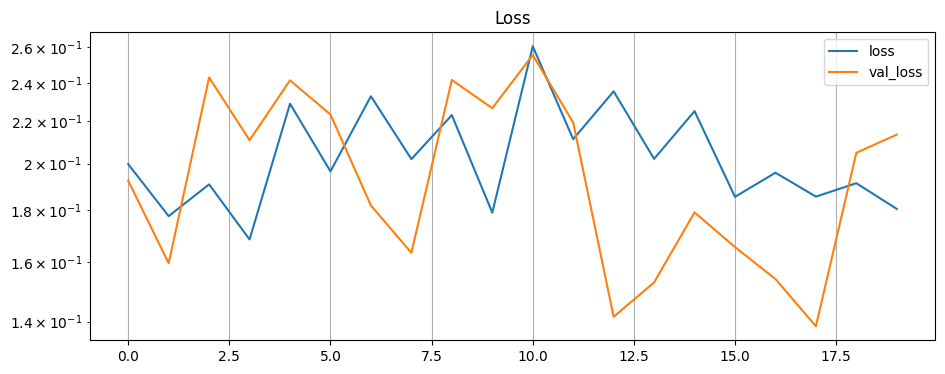

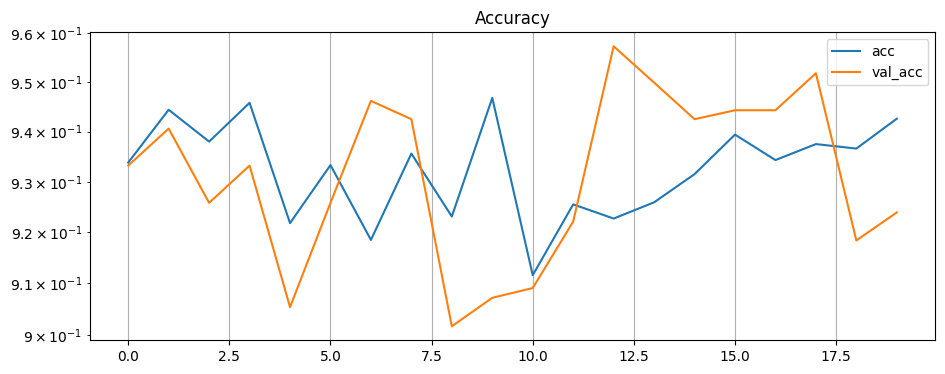

Ансамбль несильно увеличил метрику, поэтому мы перешли к разработке новой модели с бóльшим количеством слоёв.

# Лучшая модель

Принимая во внимание опыт предыдущих моделей, мы пришли к выводу, что перед подачей в полносвязные слои, размер изображения после последней свёртки должен быть не больше, чем 16384 для нашей архитектуры. Заметим, что когда количество свёрток превышает 7 штук, мы можем столкнуться с проблемой затухания градиента.

Реализуем 10-ти слойный dethick со skip connection, который был применён для избежания затухания

In [ ]:
def DeThick(input_size=(256, 256, 1)) -> tf.keras.models.Model:
    inputs = tf.keras.layers.Input(input_size)
    X = inputs
    X = tf.keras.layers.Conv2D(input_shape=input_size, filters=8, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.Activation("tanh")(X)
    X_skip = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same")(X)
    X = tf.keras.layers.MaxPool2D()(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.concatenate([X, X_skip])
    X = tf.keras.layers.Activation("tanh")(X)
    X_skip = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(X)
    X = tf.keras.layers.MaxPool2D()(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.concatenate([X, X_skip])
    X = tf.keras.layers.Activation("tanh")(X)
    X_skip = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(X)
    X = tf.keras.layers.MaxPool2D()(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.concatenate([X, X_skip])
    X = tf.keras.layers.Activation("tanh")(X)
    X_skip = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(X)
    X = tf.keras.layers.MaxPool2D()(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same")(X)
    X = tf.keras.layers.concatenate([X, X_skip])
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.AveragePooling2D()(X)
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=256)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=16)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation("tanh")(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=3, activation="softmax")(X)
    return tf.keras.models.Model(inputs, X)


In [ ]:
model = DeThick()
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)
model.summary()

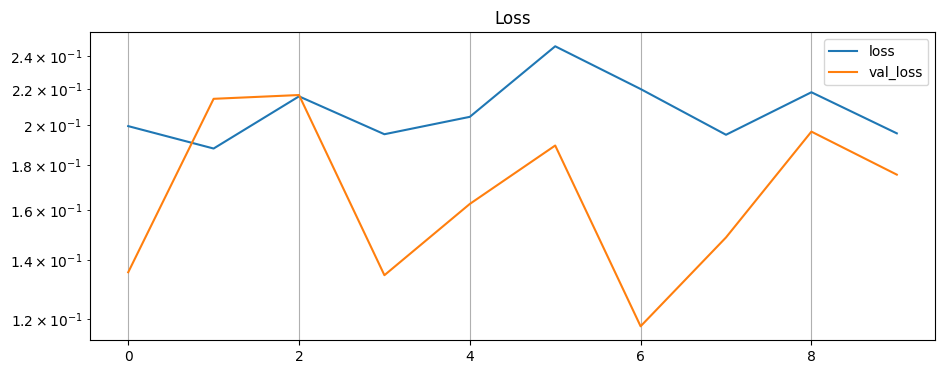

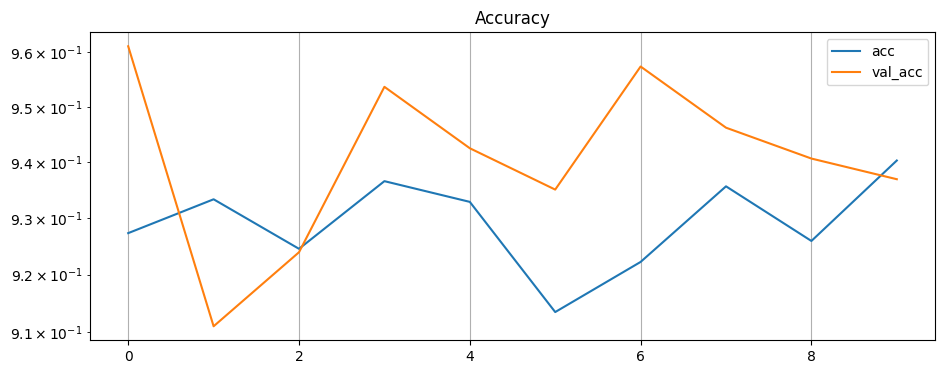

Эта модель даёт >91% F1-score.

# Вывод

Мы опробовали множество моделей, учитывая опыт которых, создали более совершенные модели, подходящие для данной, конкретной задачи классификации рентгенограмм лёгких в прямой проекции.
Сегментация отрицательно сказалась на эффективности модели.
В моделях с большим количеством свёрток желательно использовать skip-connection.
Наша лучшая модель неплохо справилась с задачей, но это не предел. Для увеличения показателей нужно:

    • Использовать аугментации данных

    • Создать и обучить 2-3 схожие модели с несколько другой архитектурой

    • Объединить их в ансамбль и подобрать лучшие коэффициенты для их предсказаний

Также не стоит забывать про проблему интерпретируемости нейросетей. В медицине крайне важно не только определять, болен человек или нет, но и указывать на то, почему нейросеть сделала такой вывод.
https://habr.com/ru/companies/otus/articles/779430/

Наша команда не смогла этого реализовать по причине нехватки времени.

Хорошего Вам дня!